#### Demo2 CAST Stack Align S4 to S1

In [1]:
import CAST
import os, torch
import warnings
warnings.filterwarnings("ignore")
work_dir = '$demo_path' #### input the demo path

Using backend: pytorch


To align the slices with preserving the cell organization, `CAST_STACK()` is used to perform gradient-descent-based rigid registration and free-form deformation (FFD) to get a proper transformation.  

Here are the parameters used in this function:  
- `coords_raw` - The dictionary of the coordinates matrix with sample name.  
- `embed_dict` - The dictionary of the graph embedding generated by CAST Mark with sample name.   
- `output_path` - The output folder path.  
- `graph_list` - The list of [`query sample`, `reference sample`]. The query sample will be aligned to the reference sample.  
- `params_dist` - The parameter dictionary for the CAST Stack.  
    - `dataname` - The dataset name.
    - `gpu` - The index of the gpu if the GPU device is available.  
    
    **Affine parameters**  
    
    - `iterations` - Iterations of the affine transformation.  
    - `alpha_basis` - The coefficient for updating the affine transformation parameter.
    - `dist_penalty1` - Distance penalty parameter in affine transformation. When the distance of the query cell to the nearest neighbor in reference sample is greater than a distance threshold (by default, average cell distance), CAST Stack will add additional distance penalty. The initial cost function value of these cells will be multiplied by the `dist_penalty1`. The value `0` indicates no additional distance penalty.
    - `bleeding` - When the reference sample is larger than the query sample, for efficient computation, only the region of the query sample with bleeding distance will be considered when calculating the cost function.  
    - `d_list` - CAST Stack will perform pre-location to find an initial alignment. The value in the `d_list` will be multiplied by the query sample to calculate the cost function. For example, 2 indicates the two-fold increase of the coordinates.
    - `attention_params` - The attention mechanism to increase the penalty of the cells. It is invalid when the `dist_penalty` = 0.  
        - `1st - attention_region` - The True/False index of all the cells of the query sample or None.
        - `2nd - double_penalty` - The `average cell distance / double_penalty` will be used in distance penalty for the cells with attention.  
        - `3rd - penalty_inc_all` - The additional penalty for the attention cells. The initial cost function value of these cells will be multiplied by `penalty_inc_all`.  
        - `4th - penalty_inc_both` - The additional penalty for the cells with distance penalty and attention. The initial cost function value of these cells will be multiplied by `(penalty_inc_both/dist_penalty + 1)`.  
        
    **FFD parameters**  
    
    - `dist_penalty2` - Distance penalty parameter in FFD. Refer to `dist_penalty1`.  
    - `alpha_basis_bs` - The coefficient for updating the FFD parameter.  
    - `meshsize` - mesh size for the FFD.  
    - `iterations_bs` - Iterations of the FFD.  
    - `attention_params_bs` - The attention mechanism to increase the penalty of the cells. Refer to `attention_params`.  
    - `mesh_weight` - The weight matrix for the mesh grid. The same size of the mesh or None.  

In [2]:
output_path = f'{work_dir}/demo2_CAST_Stack_Align_S4_to_S1/demo_output'
os.makedirs(output_path,exist_ok = True)
coords_raw = torch.load(f'{output_path}/../data/demo2_coords_raw.pt',map_location='cpu')
embed_dict = torch.load(f'{output_path}/../data/demo2_embed_dict.pt',map_location='cpu')
graph_list = ['S4','S1'] # [query_sample, reference_sample]
query_sample = graph_list[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 155.23it/s]


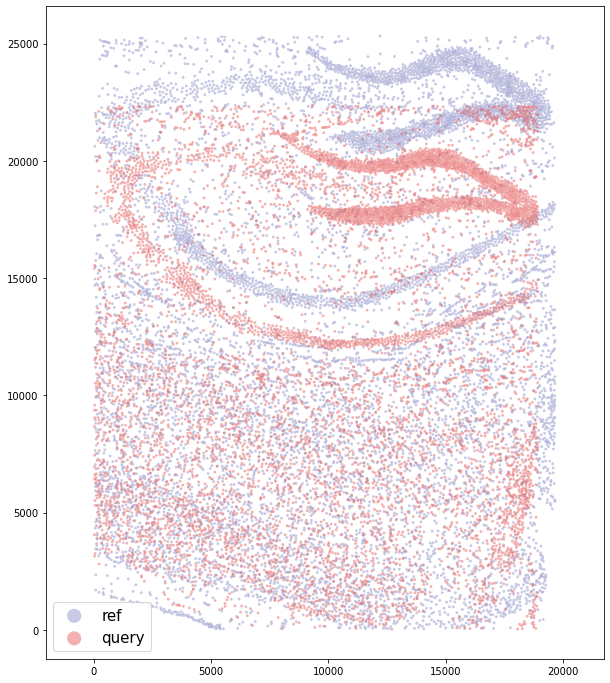

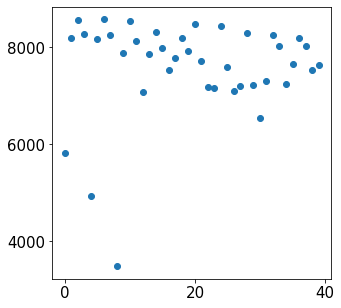

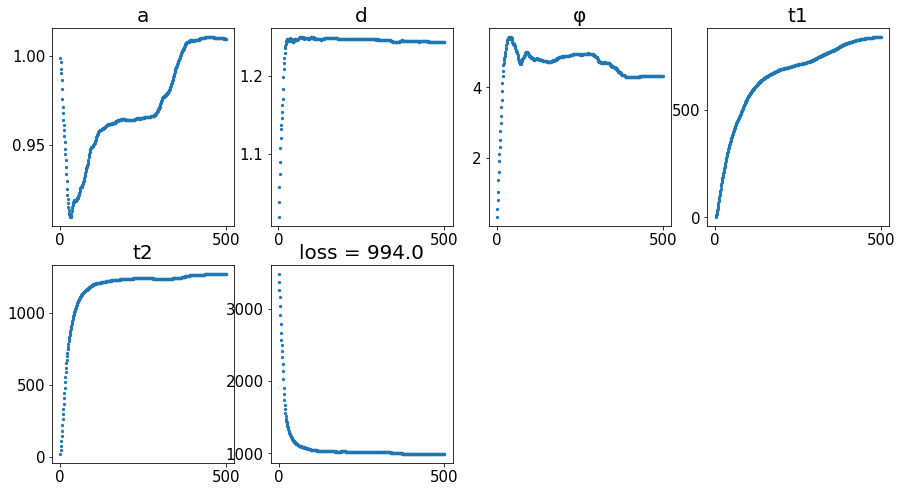

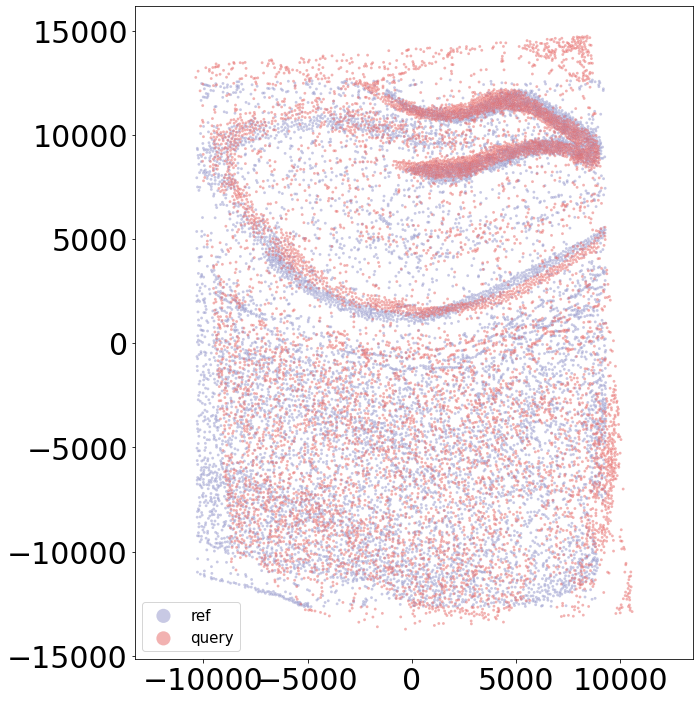

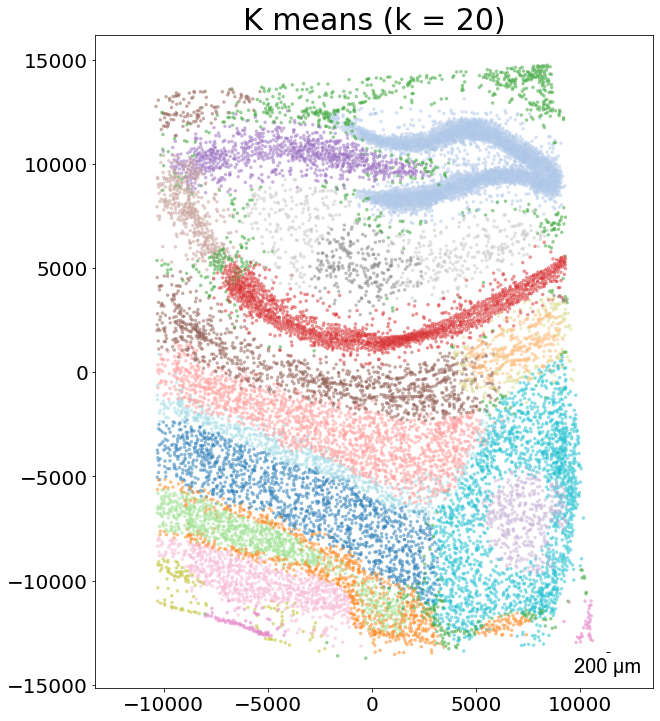

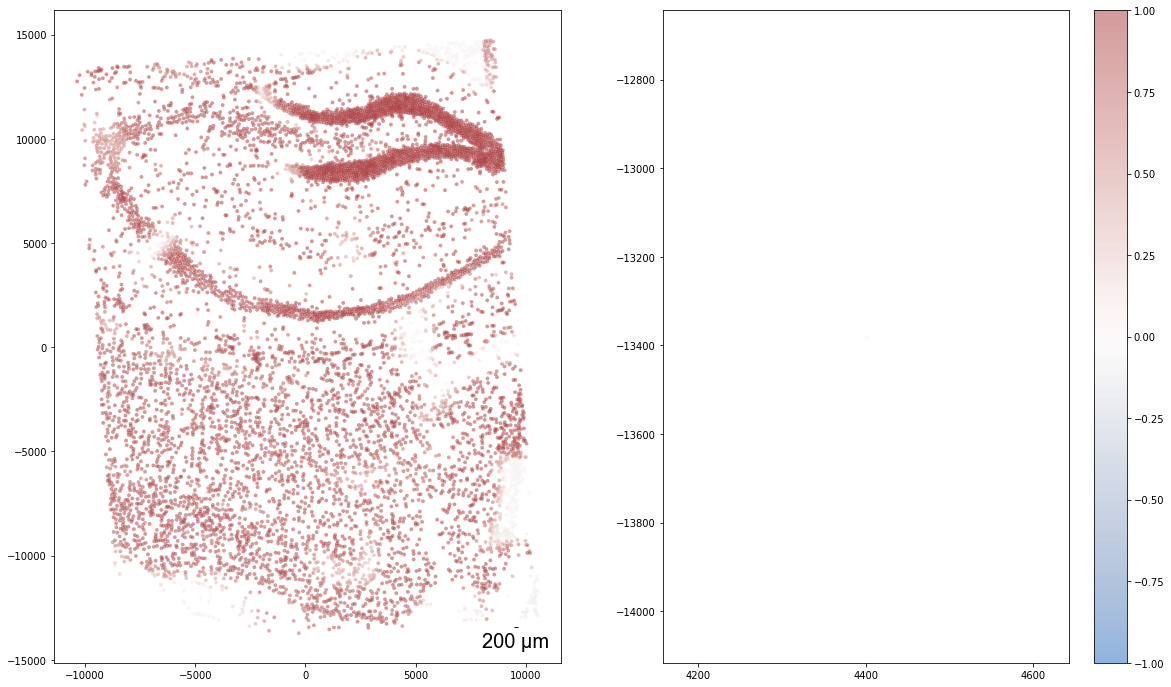

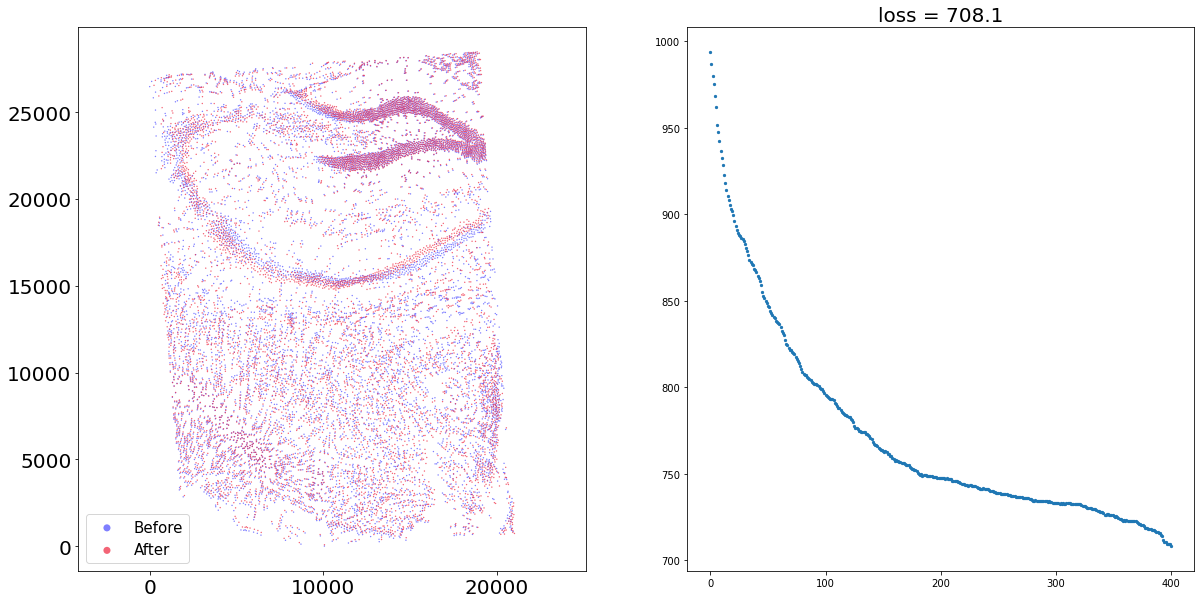

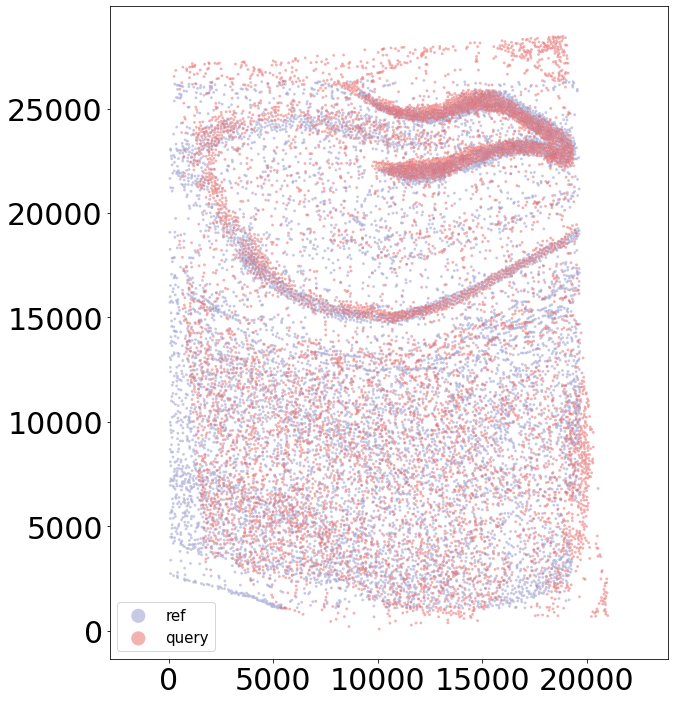

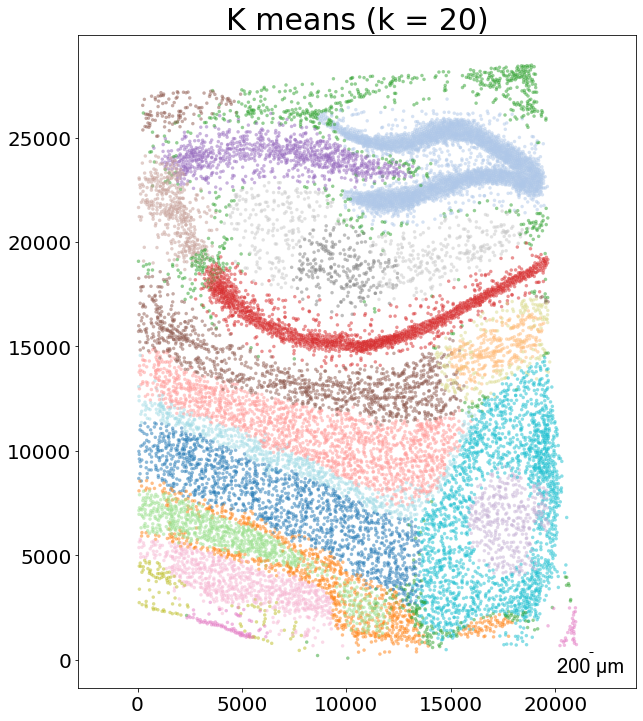

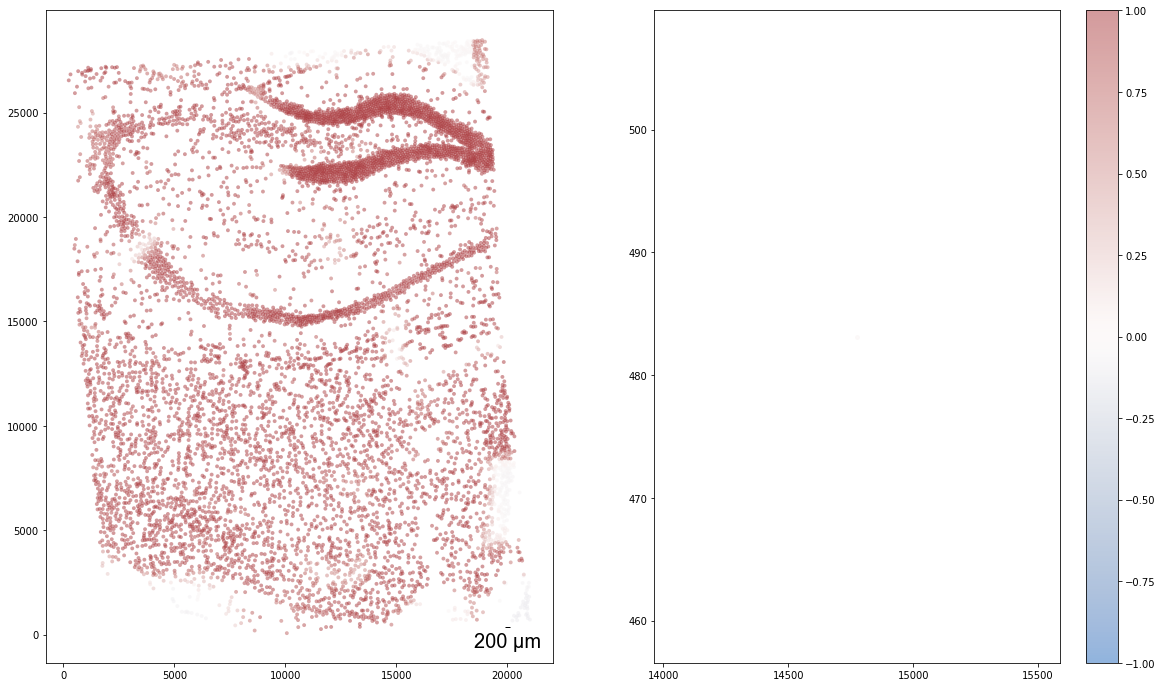

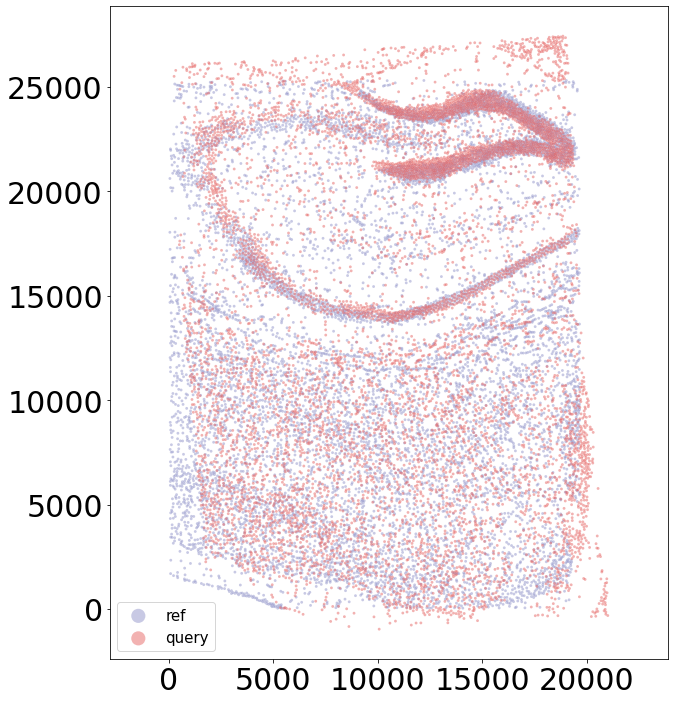

In [3]:
params_dist = CAST.reg_params(dataname = query_sample,
                            gpu = 0 if torch.cuda.is_available() else -1, 
                            diff_step = 5,
                            #### Affine parameters
                            iterations=500,
                            dist_penalty1=0,
                            bleeding=500,
                            d_list = [3,2,1,1/2,1/3],
                            attention_params = [None,3,1,0], 
                            #### FFD parameters    
                            dist_penalty2 = [0],
                            alpha_basis_bs = [500],
                            meshsize = [8],
                            iterations_bs = [400],
                            attention_params_bs = [[None,3,1,0]],
                            mesh_weight = [None])
params_dist.alpha_basis = torch.Tensor([1/1000,1/1000,1/50,5,5]).reshape(5,1).to(params_dist.device)
coords_final = CAST.CAST_STACK(coords_raw,embed_dict,output_path,graph_list,params_dist)